In [1]:
#Importo librerías necesarias
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import os
import visual as v

#Cuestiones previas:
###1. La forma de guardar la información de las masas es la siguiente:
+ Cada una tiene tres componentes: la masa, un vector $r$ (que contiene posición en $\hat{\textbf{i}}$, $\hat{\textbf{j}}$ y $\hat{\textbf{k}}$) y un vector $v$ (que contiene velocidad en $\hat{\textbf{i}}$, $\hat{\textbf{j}}$ y $\hat{\textbf{k}}$).
+ El array InfoInicial contiene la información de **todas** las masas en cuestión. Cada componente es la información de una masa. Cada una de estas componentes a su vez es otro vector con las componentes antes descritas. El orden de la información contenida en este array es: [$M_1, M_2, \dots , M_n$]. Donde cada $m_i$ es un array de la forma [$m_i, r_i, v_i$].
+ Las masas se encuentran expresadas en términos de masas de Júpiter ($1.89813 \times 10^{27} kg$). Por lo tanto la constante $G$ utilizada cambia de esta manera: $G_{utilizada} = G \times 1.89813 \times 10^{27}$. Así entonces $G_{utilizada} = 1.26678159192 \times 10^{17} \frac{N m^2}{Kg^2}$.

###2. Utilizamos la siguiente fórmula para definir la interacción gravitacional:

$$\\ m_i \frac{d^2 r}{dt^2} = -G \sum_{i \neq j} \frac{m_i m_j (r_i - r_j)}{|r_{i} - r_{j}|^3}\\$$
$$i = 1, \dots , N$$

###3. Utilizamos la siguiente fórmula para definir la energía potencial gravitatoria:

$$\\ U_G(r) = -G \sum_{i \neq j} \frac{m_i m_j}{|r_{i} - r_{j}|}\\$$
$$i = 1, \dots , N$$

###4. Utilizamos la siguiente fórmula para definir la energía cinética:

$$\\ K(v) = \sum_i \frac{m_i v_i^2}{2}$$

###5. Utilizamos la siguiente fórmula para definir la energía total:

$$\\ E = U + K$$

###6. Utilizamos el método de Runge-Kutta de orden 4 para resolver las ecuaciones diferenciales de movimiento. Recordando que este se basa en que:

$$\frac{d}{dt} Y(t) = f(Y)$$

###7. Todo lo aquí hecho se basa en la información tomada de las fuentes: [1](http://www14.in.tum.de/konferenzen/Jass05/courses/2/Lapshin/Lapshin_paper.pdf), [2](http://radio.astro.gla.ac.uk/a1dynamics/pw/code/simple-3-body.py), [3](https://github.com/ComputoCienciasUniandes/MetodosComputacionales/blob/master/slides/2015-V/10-ODE.ipynb), [4](https://es.wikipedia.org/wiki/Energ%C3%ADa_gravitatoria), [5](http://physics.nist.gov/cgi-bin/cuu/Value?bg), [6](https://github.com/OpenExoplanetCatalogue/open_exoplanet_catalogue), [7](http://www.openexoplanetcatalogue.com/planet/Gliese%20667%20C%20h/).

###8. A conitnuación se definen las funciones a utilizar:

In [2]:
G = 1#1.26678159192e17

In [3]:
#Basados en el inciso (2) y la fuente 1 definimos la función de m*a. Que para el método Runge-Kutta sería la velocidad.
def f(Y,M):
    global G
    info = [] #Toda la información se guarda en esta variable local, que al final del método es retornada.
    for i in range(0,len(Y),2): #Este ciclo recorre cada una de las masas.
        v = 0
        #Este ciclo encuentra la atracción que siente cada una de las masas efectuada por las demás.
        for j in range(0,len(Y),2):
            if (i != j): #Utilizamos esta condición para evitar calcular la fuerza que una masa ejerce sobre sí misma.
                v -= G*(M[int(j/2)])*((Y[i] - Y[j]) / norm(Y[i] - Y[j])**3)
        info.extend((Y[i+1],v))
    informacion = np.array(info)
    return(informacion)

In [4]:
#Basados en las fuentes 2 y 3 implementamos el método de Runge-Kutta de orden 4.
def runge_kutta_orden4(dt,Y,M):
    #Resolvemos las ecuaciones de movimiento con Runge-Kutta orden 4.
    K1 = f(Y,M)
    K2 = f(Y + dt*(1./2.*K1),M)
    K3 = f(Y + dt*(1./2.*K2),M)
    K4 = f(Y + dt*K3,M)
    #Asignamos los nuevos valores encontrados al vector inicial.
    Y+= dt * (1/6.*K1 + 1/3. * K2 + 1/3.*K3 + 1/6.*K4)
    return(Y)

In [5]:
#Calcula la velocidad del centro de masa del sistema.
def vcentre(Y,M):
    vcentre = 0
    mass = 0
    for i in range(0,len(Y),2):
        vcentre += Y[i+1]*M[int(i/2)]
        mass += M[int(i/2)]
    return (vcentre/mass)

In [6]:
#Definimos una función que llama varias veces el método de Runge-Kutta para efectuar la simulación.
def simulacion(M,Y,numIter=100,tmax=1,*args):
    #dt = tmax/numIter #Se cuadra la escala de tiempo para que 1 periodo se ajuste al dt del método.
    dt = 0.1
    history=np.array([Y]) #Este array contendrá la información luego de cada iteración con el fin de poder graficar.
    for iters in range(numIter):#Se ejecuta el método Runge-Kutta  durante la cantidad de iteraciones propuestas
        history=np.append(history,[runge_kutta_orden4(dt,history[-1],M)],axis=0)
    return (history)

In [35]:
#Definimos una función que grafica basados en los datos arrojados por la simulación
#Se pasa por parámetro la historia de la simulación y la trayectoria de la masa que se quiere graficar
#Si no se pasa ninguna masa por parámetro (o se iguala a 0) muestra la trayectoria de todas las masas
def graficador(history,masa=0,**args):
    colors = cm.rainbow(np.linspace(0, 1, len(history[0])/2))
    if (masa == 0):
        plt.figure(figsize=(14,4))
        plt.axis('equal')
        for i in range(0,(int(len(history[0]))),2):
            plt.scatter(history[:,i][:,0],history[:,i][:,1],s=1)
            plt.scatter(history[:,i][:,0][0],history[:,i][:,1][0],s=50,label="Inicio",color=colors[int(i/2)])
        plt.legend(loc=0)
        plt.xlabel(u'Posición $x$')
        plt.ylabel(u'Posición $y$')
        plt.title(u'Trayectorias de las masas',fontsize=15)
        plt.show()
    else:
        plt.figure(figsize=(14,4))
        plt.axis('equal')
        plt.scatter(history[:,int((masa-1)*2)][:,0],history[:,int((masa-1)*2)][:,1],s=1)
        plt.scatter(history[:,int((masa-1)*2)][:,0][0],history[:,int((masa-1)*2)][:,1][0],s=50,label="Inicio",color='blue')
        plt.scatter(history[:,int((masa-1)*2)][:,0][-1],history[:,int((masa-1)*2)][:,1][-1],s=50,label="Fin",color='red')
        plt.legend(loc=0)
        plt.xlabel(u'Posición $x$')
        plt.ylabel(u'Posición $y$')
        plt.title(u'Trayectoria de $m_{%d}$'%masa,fontsize=15)
        plt.show()

In [36]:
#Animador
def animador(history):
    colors = cm.rainbow(np.linspace(0, 1, len(history[0])/2))
    for j in range(0,len(history),20):#Recorre toda la historia para graficar cada paso
        plt.figure(figsize=(9,7))
        plt.axis('equal')
        #plt.plot(history[:,0][:,0],history[:,0][:,1],'--',color='grey')
        #xlim = plt.gca().get_xlim()
        #ylim = plt.gca().get_ylim()
        plt.xlim(-20,20)#xlim)
        plt.ylim(-15,20)#ylim)
        for i in range(0,(int(len(history[0]))),2):#Grafica todas las masas por cada paso
            plt.scatter(history[:,i][:,0][j],history[:,i][:,1][j],s=50,color=colors[int(i/2)])
        plt.grid()
        plt.xlabel(u'Posición $x$')
        plt.ylabel(u'Posición $y$')
        plt.title('Gravitational Choreography',fontsize=15)
        plt.savefig('anim%d.png'%j)#Guarda las gráficas realizadas
        plt.cla()
        plt.close()
    os.system("convert -delay 12 -loop 0 $(ls anim*.png | sort -V) gravchorN%d.gif"%(int(len(history[0])/2)))
    os.system("rm anim*.png")#Toma las gráficas, las convierte en un .gif y las elimina

In [37]:
#m1 = np.array([10])
m1 = 10
r1 = np.array([10,0,0])
v1 = np.array([0,1,0])
#M1 = np.array([m1,r1,v1])

#m2 = np.array([10])
m2 = 10
r2 = np.array([-10,0,3])
v2 = np.array([-0.3,-1,0.5])
#M2 = np.array([m2,r2,v2])

#m3 = np.array([10])
m3 = 10
r3 = np.array([0,0,0])
v3 = np.array([0,0.1,0.1])
#M3 = np.array([m3,r3,v3])

InfoInicial = np.array([r1,v1,r2,v3,r3,v3])
masas = np.array([m1,m2,m3])

In [38]:
InfoInicial[1::2] -= vcentre(InfoInicial,masas)
InfoInicial

array([[ 10.        ,   0.        ,   0.        ],
       [  0.        ,   0.6       ,  -0.06666667],
       [-10.        ,   0.        ,   3.        ],
       [  0.        ,  -0.3       ,   0.03333333],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,  -0.3       ,   0.03333333]])

In [39]:
vcentre(InfoInicial,masas)

array([  0.00000000e+00,  -2.96059473e-17,   3.70074342e-18])

In [40]:
InfoInicial[1::2] -= vcentre(InfoInicial,masas)
InfoInicial

array([[ 10.        ,   0.        ,   0.        ],
       [  0.        ,   0.6       ,  -0.06666667],
       [-10.        ,   0.        ,   3.        ],
       [  0.        ,  -0.3       ,   0.03333333],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,  -0.3       ,   0.03333333]])

In [41]:
vcentre(InfoInicial,masas)

array([ 0.,  0.,  0.])

In [42]:
InfoInicial

array([[ 10.        ,   0.        ,   0.        ],
       [  0.        ,   0.6       ,  -0.06666667],
       [-10.        ,   0.        ,   3.        ],
       [  0.        ,  -0.3       ,   0.03333333],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,  -0.3       ,   0.03333333]])

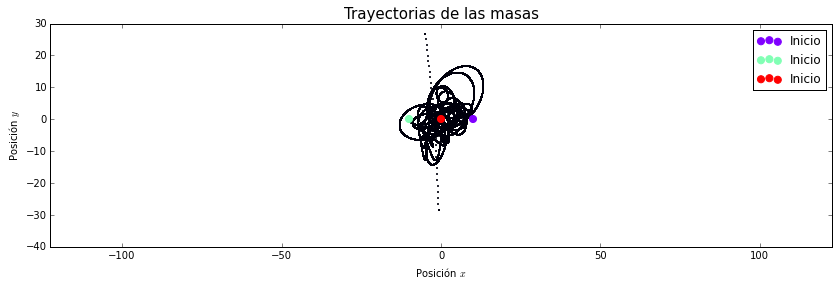

In [43]:
#Corremos la simulación para media unidad de tiempo y graficamos resultados.
hist=simulacion(Y=InfoInicial,M=masas,numIter=3400)
#graficador(hist,masa=1)
#graficador(hist,masa=2)
#graficador(hist,masa=3)
graficador(hist)

In [160]:
animador(hist)

###(b) Las trayectorias son periódicas, calcule el periodo con por lo menos tres cifras significativas.

In [11]:
#Utilizamos la función previamente definida para encontrar el periodo.
T = tfinder(Y=YN3,iteraciones=10)
print('El periodo de las trayectorias es de aproximadamente %.5f unidades de tiempo.'%T)

Iteración número 1
Iteración número 2
Terminé y lo encontré :)
El periodo de las trayectorias es de aproximadamente 0.79480 unidades de tiempo.


###(c) Haga una animación de las trayectorias de los tres cuerpos.

In [12]:
#Corremos la simulación nuevamente, pero esta vez para el periodo encontrado. Luego utilizamos la función que crea
#la animación previamente definida.
hist=simulacion(numIter=200,Y=YN3,tmax=T)
animador(hist)

###La animación se puede encontrar en el siguiente [enlace](https://raw.githubusercontent.com/diegolramirez/MC/master/Tareas/HW5/gravchorN3.gif).

###(b) Con el valor de $a$ encontrado haga una gráfica con la energía cinética, la energía potencial y la energía total del sistema en función del tiempo.

In [19]:
#Basados en el inciso (3) y la fuente 1 definimos la función de energía potencial.
def U(Y):
    info = [] #Toda la información se guarda en esta variable local, que al final del método es retornada.
    for i in range(0,len(Y),2): #Este ciclo recorre cada una de las masas.
        u = 0
        #Este ciclo encuentra la energía potencial que siente cada una de las masas efectuada en relación a las demás.
        for j in range(0,len(Y),2):
            if (j > i): #Utilizamos esta condición para evitar calcular doble las fuerzas potenciales.
                u -= 1./norm(Y[i] - Y[j])
        info.append(u)
    informacion = np.array(info).sum()
    return(informacion)

In [20]:
#Basados en el inciso (4) y la fuente 1 definimos la función energía cinética.
def K(Y):
    info = [] #Toda la información se guarda en esta variable local, que al final del método es retornada.
    for i in range(1,len(Y),2): #Este ciclo recorre cada una de las masas.
        k = (norm(Y[i])**2)/2.
        info.append(k)
    informacion = np.array(info).sum()
    return(informacion)

In [21]:
#Definimos una función que recorre la historia de la simulación y encuentra y encuentra U, K y E.
def energias(history):
    energiaU=np.array([])#Creamos arrays que contendran la info de U y K.
    energiaK=np.array([])
    for i in history:#Recorremos la historia y hallamos U y K en cada step.
        energiaU=np.append(energiaU,[U(i)],axis=0)
        energiaK=np.append(energiaK,[K(i)],axis=0)
    total = energiaU + energiaK #Sumamos energías U + K para hallar E.
    return (np.array([energiaU,energiaK,total]))

In [22]:
#Corremos la función que encuentra las energías.
eU,eK,eT = energias(hist)
#Definimos un linspace que representa el tiempo.
t = np.linspace(0,1,len(hist))

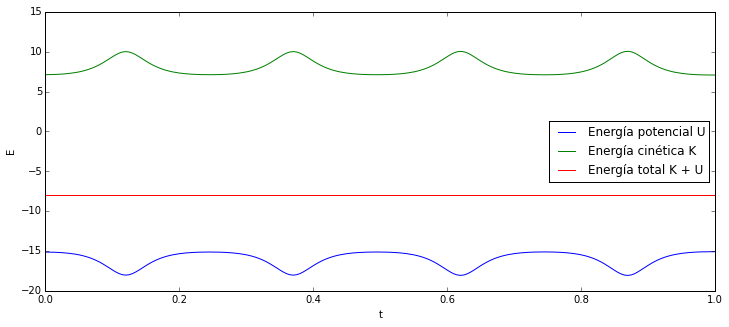

In [23]:
#Hacemos la gráfica de U,K,E.
plt.figure(figsize=(12,5))
plt.plot(t,eU,label='Energía potencial U',color='blue')
plt.plot(t,eK,label='Energía cinética K',color='green')
plt.plot(t,eT,label='Energía total K + U',color='red')
plt.xlabel('t')
plt.ylabel('E')
plt.legend(loc=0)

###(c) Haga una animación de las trayectorias de los cuatro cuerpos.

In [24]:
#Hacemos la animación con la función previamente definida.
animador(hist)

###La animación se puede encontrar en el siguiente [enlace](https://raw.githubusercontent.com/diegolramirez/MC/master/Tareas/HW5/gravchorN4.gif).

In [13]:
norm([2,2,2])

3.4641016151377544

In [12]:
np.sqrt(12)

3.4641016151377544

In [ ]:
#Basados en el inciso (2) y la fuente 1 definimos la función de m*a. Que para el método Runge-Kutta sería la velocidad.
def f(Y):
    global G
    info = [] #Toda la información se guarda en esta variable local, que al final del método es retornada.
    for i in range(len(Y)): #Este ciclo recorre cada una de las masas.
        v = 0
        #Este ciclo encuentra la atracción que siente cada una de las masas efectuada por las demás.
        for j in range(len(Y)):
            if (i != j): #Utilizamos esta condición para evitar calcular la fuerza que una masa ejerce sobre sí misma.
                v -= G*(Y[i][0]*Y[j][0])*((Y[i][1] - Y[j][1]) / norm(Y[i][1] - Y[j][1])**3)
        info.extend((Y[i+1],v))
    informacion = np.array(info)
    return(informacion)

In [16]:
a = np.array([1,2])
b = np.array([3,4,5])

In [20]:
c = np.array([a,b,1])

In [21]:
c

array([array([1, 2]), array([3, 4, 5]), 1], dtype=object)

In [31]:
m1 = np.array([10])
r1 = np.array([10,0,0])
v1 = np.array([0,1,0])


In [32]:
a = np.array([m1,r1,v1])

In [33]:
a

array([array([10]), array([10,  0,  0]), array([0, 1, 0])], dtype=object)

In [21]:
r1

array([10,  0,  0])

In [22]:
v1

array([0, 1, 0])

In [29]:
x = np.array([v1,r1,1])

In [30]:
a = np.array([m1,r1,v1])

array([array([0, 1, 0]), array([10,  0,  0]), 1], dtype=object)

In [48]:
6.67384e-11*1.898e27*(1./149597871000)**3*(86400**2)

2.824380763307379e-07

In [52]:
200*365

73000

In [54]:
2*np.pi*6.5/(200*365)

0.0005594617054337989

In [55]:
np.sin(90)

0.89399666360055785

In [56]:
np.rad2deg(1)

57.295779513082323

In [57]:
np.sin(1)

0.8414709848078965

In [58]:
np.sin(30)

-0.98803162409286183

In [63]:
200*np.sin(np.deg2rad(50))

153.20888862379562

In [64]:
200*np.cos(np.deg2rad(50))

128.55752193730788

In [65]:
def velocidaddd(r,t):
    return((2*np.pi*r)/t)

In [72]:
t=256
r=0.55
velocidaddd(r,t)

0.013499030933393644